In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# LangGraph Streaming

In [3]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

/Users/a09758/KDT/AI-Agent-대중소상생/skala_gai/.venv1/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


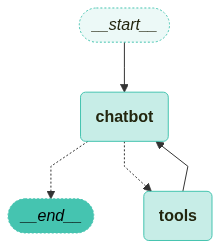

In [4]:
########## 1. State ##########
class State(TypedDict):
    messages: Annotated[list, add_messages]
    dummy_date: Annotated[str, "dummy"]


########## 2. TOOLS ##########
# 도구 초기화
news_tool = GoogleNews()

# 키워드 뉴스 검색 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM + 도구 
llm_with_tools = llm.bind_tools(tools)


########## 3. NODE ##########
# 챗봇 함수 정의
def chatbot(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] 호출, dummy data",  # 테스트를 위하여 더미 데이터를 추가
    }


# Graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Conditional Edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


########## 4. EDGE ##########
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


########## 5. COMPILE ##########
graph = graph_builder.compile()


########## 6. VISUALIZE ##########
visualize_graph(graph)

## StateGraph의 `stream` 메서드

개요
- 에이전트의 실행 과정을 스트리밍 방식으로 추적하거나, 
- 외부에서 실시간으로 결과를 처리하고자 할 때 사용하는 메서드 
- `stream()`은 중간 노드의 실행 결과나 상태 전이를 순차적으로 받을 수 있음 

주요 기능
1. 입력된 설정에 따라 그래프 실행을 스트리밍 방식으로 처리
2. 다양한 스트리밍 모드 지원 (`values`, `updates`, `debug`)
3. 콜백 관리 및 오류 처리
4. 재귀 제한 및 중단 조건 처리

스트리밍 모드
- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력
- `debug`: 각 단계의 디버그 이벤트 출력

매개변수
- `input` (Union[dict[str, Any], Any]): 그래프에 대한 입력
- `config` (Optional[RunnableConfig]): 실행 구성
- `stream_mode` (Optional[Union[StreamMode, list[StreamMode]]]): 출력 스트리밍 모드
- `output_keys` (Optional[Union[str, Sequence[str]]]): 스트리밍할 키
- `interrupt_before` (Optional[Union[All, Sequence[str]]]): 실행 전에 중단할 노드
- `interrupt_after` (Optional[Union[All, Sequence[str]]]): 실행 후에 중단할 노드
- `debug` (Optional[bool]): 디버그 정보 출력 여부
- `subgraphs` (bool): 하위 그래프 스트리밍 여부

반환값
- Iterator[Union[dict[str, Any], Any]]: 그래프의 각 단계 출력. 출력 형태는 `stream_mode`에 따라 다름

In [5]:
from langchain_core.runnables import RunnableConfig

In [6]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  
    configurable={"thread_id": "001"},  
    tags=["MY-TAG"],  # 디버깅, 로딩, 대시보드 분석 시 유용 
)

In [7]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")

        if "messages" in value:
            messages = value["messages"]
            value["messages"][-1].pretty_print() # 가장 최근 메시지 1개만 출력


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_7w4UddaVD5NGMWK8TSnzKzXL)
 Call ID: call_7w4UddaVD5NGMWK8TSnzKzXL
  Args:
    query: 2024 Nobel Prize in Literature

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiigFBVV95cUxNblM5bndNclA5Q0J2RW9NZ09XRTdyZ0ZhZ3diZUpodEU2WlhaVzFVZ3doZjI1ZEF6dGF5SnVQUVdCdF9tNUJnWjZ1LV8xTlNqT01xZmFaQ2NNNVdkM1RtR0ZCb0tDUzVZQk5oLVp1d1dpX2x2V2g4R3dKV0V3NVNvclRNa3VOSjIxWWc?oc=5", "content": "Han Kang – Nobel Prize lecture in Korean - NobelPrize.org - NobelPrize.org"}, {"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxNRGxDMlZxRnFuS1ZxTW1JZmhyNFZlRUVzb2UzbWJYbkhUSTB1OTF0dU5BM2VEU25SNnlFejd4LXoxUjEtVmZrTm1sWTZyb2U4UXBUeXExOHVhVXduSXJ2LWt3ZGJUS0VLQ1N2U2dSNkw3elN4UjRnLXFzNDBkWWkyZjFFSQ?oc=5", "content": "한강 \"문학, 생명을 파괴하는 모든 행위에 반대하는 일\" - Korea.net"}, {"url"

### `output_keys`

- `output_keys` : 스트리밍할 키를 지정하는 데 사용
- list 형식으로 지정할 수 있으며, channels 에 정의된 키 중 하나
- 매 단계마다 출력되는 State key 가 많은 경우, 일부만 스트리밍하고 싶은 경우에 유용

In [8]:
# channels 에 정의된 키 목록 출력
print(list(graph.channels.keys()))

['messages', 'dummy_date', '__start__', 'branch:to:chatbot', 'branch:to:tools']


In [9]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  
    configurable={"thread_id": "001"}, 
    tags=["MY-TAG"],  
)

In [10]:
for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],
):
    for key, value in event.items():
        print(f"\n[ {key} ]\n") # key는 노드 이름

        # dummy_data 가 존재하는 경우
        if value:
            print(value.keys())
            
            if "dummy_data" in value:
                print(value["dummy_data"])


[ chatbot ]

dict_keys(['messages'])

[ tools ]

dict_keys(['messages'])

[ chatbot ]

dict_keys(['messages'])


### `stream_mode` 

- `values`: 각 단계의 현재 상태 값 출력 
- `updates`: 각 단계의 상태 업데이트만 출력 (기본값)

In [11]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10, 
    configurable={"thread_id": "001"},  
    tags=["MY-TAG"], 
)

# values 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="values",  # default
):
    for key, value in event.items():
        # key 는 state 의 key 값
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"메시지 개수: {len(value)}")
            # print(value)
    print("===" * 10, " 단계 ", "===" * 10)


[ messages ]

메시지 개수: 1
==============================  단계  ==============================

[ messages ]

메시지 개수: 2
==============================  단계  ==============================

[ messages ]

메시지 개수: 3
==============================  단계  ==============================

[ messages ]

메시지 개수: 4
==============================  단계  ==============================


#### `stream_mode = "updates"`

- `updates` 모드는 각 단계에 대한 업데이트된 State 만 내보냄
- 출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 `dictionary` 

`event.items()`
- `key`: 노드(Node) 의 이름
- `value`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.

In [12]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10,  
    configurable={"thread_id": "0011"},
    tags=["MY-TAG"], 
)

# updates 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="updates",  # default
):
    for key, value in event.items():
        print(f"\n[ {key} ]\n") # key 는 노드 이름
        print(value.keys()) # value 는 노드의 출력값

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
            # print(value["messages"])
    print("===" * 10, " 단계 ", "===" * 10)


[ chatbot ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================

[ tools ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================

[ chatbot ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================


### `interrupt_before`, `interrupt_after`

- `interrupt_before`: 지정된 노드 이전에 스트리밍 중단
- `interrupt_after`: 지정된 노드 이후에 스트리밍 중단

In [13]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10,  
    configurable={"thread_id": "0011"},
    tags=["MY-TAG"], 
)


for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # default
    interrupt_before=["tools"],  # tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        print(f"\n[{key}]\n")
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)


[chatbot]

dict_keys(['messages'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iFwID9dxNEq4OTHxKmiVKYaa', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8b32220a-59bb-471d-b640-8e3bc6a7ecd9-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_iFwID9dxNEq4OTHxKmiVKYaa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 19, 'total_tokens': 76, 'input_toke

In [14]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10, 
    configurable={"thread_id": "0011"}, 
    tags=["MY-TAG"], 
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[__interrupt__]

dict_keys(['messages'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tlVBkaFkxeUkv4bqetMUeOeo', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--24dbc081-2ab4-44a2-b1a5-9455fec61df7-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_tlVBkaFkxeUkv4bqetMUeOeo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 19, 'total_tokens': 76, 'inpu

-----
** End of Documents **